# Prepare data for training dataframe

The aim is to produce a training table where each `order_id` is mapped to all coupons available in the departments from which products were selected in that order on the date the order was made, along with information (`True`/`False`) if such available coupon was used in that order.

The steps are as follows:
1. Create `coupon_date_department` table which maps coupons to applicable departments, to coupon validity dates
2. Create `order_date_department` table which maps orders to departments from which products were ordered, to order dates.
3. Create `order_coupons_available` by merging the tables above on date and department - this will create a table which maps orders and coupons available at that order date, but limited by departments (i.e. rows are selected only if order contained products from a department for which there was a coupon)
4. Create `order_coupons_used` - by dropping columns from `order_details`, leaving only a mapping between order and coupons used in that order.
5. Cobine 3 and 4 to create a dataset with coupons and orders mapped, with information whether coupon was used or not.
6. Add details about customers (such as age, gender, etc., and also some statistics about customer purchases)
7. Add details about coupons (type, discount, mean product pric, etc.)

In [1]:
import datetime
import os

from IPython.display import Image
import numpy as np
import pandas as pd

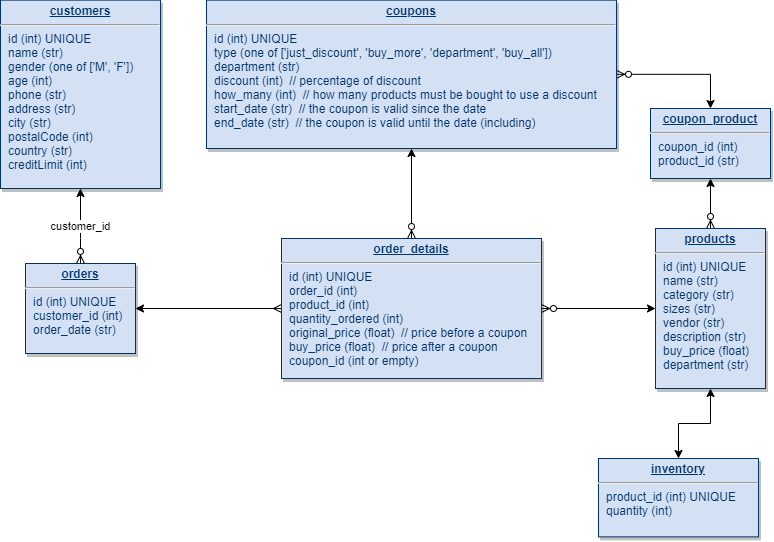

In [2]:
Image('data_diagram.png')

#### Step 0. Read and prepare tables

In [3]:
data_dir = 'data_0408_0'

In [4]:
coupons = pd.read_csv(os.path.join(data_dir, 'coupons.csv'))
coupons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1033 entries, 0 to 1032
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          1033 non-null   int64 
 1   type        1033 non-null   object
 2   department  62 non-null     object
 3   discount    1033 non-null   int64 
 4   how_many    1033 non-null   int64 
 5   start_date  1033 non-null   object
 6   end_date    1033 non-null   object
dtypes: int64(3), object(4)
memory usage: 56.6+ KB


In [5]:
coupons.rename(columns={'id': 'coupon_id'}, inplace=True)
coupons.start_date = pd.to_datetime(coupons.start_date, format='%Y-%m-%d')
coupons.end_date = pd.to_datetime(coupons.end_date, format='%Y-%m-%d')

In [6]:
coupon_product = pd.read_csv(os.path.join(data_dir, 'coupon_product.csv'))
coupon_product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812 entries, 0 to 1811
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   coupon_id   1812 non-null   int64
 1   product_id  1812 non-null   int64
dtypes: int64(2)
memory usage: 28.4 KB


In [7]:
products = pd.read_csv(os.path.join(data_dir, 'products.csv'))
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           3000 non-null   int64  
 1   name         3000 non-null   object 
 2   category     3000 non-null   object 
 3   sizes        3000 non-null   object 
 4   vendor       3000 non-null   object 
 5   description  3000 non-null   object 
 6   buy_price    3000 non-null   float64
 7   department   3000 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 187.6+ KB


In [8]:
products.rename(columns={'id': 'product_id'}, inplace=True)

In [9]:
orders = pd.read_csv(os.path.join(data_dir, 'orders.csv'))
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308313 entries, 0 to 308312
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           308313 non-null  int64 
 1   customer_id  308313 non-null  int64 
 2   order_date   308313 non-null  object
dtypes: int64(2), object(1)
memory usage: 7.1+ MB


In [10]:
orders.sample(5)

,id,customer_id,order_date
166938,166939,212,2011-08-15 16:24:53
183539,183540,274,2011-10-14 10:57:56
274010,274011,158,2012-08-30 11:15:48
46785,46786,740,2010-06-15 15:19:19
153207,153208,660,2011-06-28 09:54:40


In [11]:
orders.rename(columns={'id': 'order_id', 'order_date': 'date'}, inplace=True)
orders.date = pd.to_datetime(orders.date, format='%Y-%m-%d').dt.date

In [12]:
order_details = pd.read_csv(os.path.join(data_dir, 'order_details.csv'))
order_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2297759 entries, 0 to 2297758
Data columns (total 7 columns):
 #   Column            Dtype  
---  ------            -----  
 0   id                int64  
 1   order_id          int64  
 2   product_id        int64  
 3   quantity_ordered  int64  
 4   original_price    float64
 5   buy_price         float64
 6   coupon_id         float64
dtypes: float64(3), int64(4)
memory usage: 122.7 MB


In [13]:
order_details.drop(['id'], axis=1, inplace=True)

In [14]:
order_details.sample(5)

,order_id,product_id,quantity_ordered,original_price,buy_price,coupon_id
1789646,240717,2642,4,7.63,7.6300,NaN
940699,125187,859,2,3.09,2.9355,417.0
763067,100890,1877,4,81.99,45.0945,338.0
672868,88426,898,7,3.60,3.6000,NaN
1142583,153580,2477,3,8.12,4.1412,514.0


In [15]:
customers = pd.read_csv(os.path.join(data_dir, 'customers.csv'))
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           1000 non-null   int64 
 1   name         1000 non-null   object
 2   gender       1000 non-null   object
 3   age          1000 non-null   int64 
 4   phone        1000 non-null   object
 5   address      1000 non-null   object
 6   city         1000 non-null   object
 7   state        1000 non-null   object
 8   postalCode   1000 non-null   int64 
 9   country      1000 non-null   object
 10  creditLimit  1000 non-null   int64 
dtypes: int64(4), object(7)
memory usage: 86.1+ KB


In [16]:
customers.rename(columns={'id': 'customer_id'}, inplace=True)

In [17]:
customers.sample(5)

,customer_id,name,gender,age,phone,address,city,state,postalCode,country,creditLimit
510,511,Travarious Wolff,M,37,(359)461-8875,138 Davis Road,Watertown,Massachusetts,2272,US,5483
757,758,Jhade Stracke,F,56,(282)145-1638,47 Central Trail,Absaraka,North Dakota,58002,US,4845
858,859,Treydan MD,M,19,(793)753-7311,119 View Court,Savanna,Oklahoma,74565,US,9810
74,75,Evelynn DVM,F,66,(945)774-6546,160 Cherry Court,Chewelah,Washington,99109,US,9202
815,816,Saedie Sr.,F,36,(188)487-2981,323 4th Trail,Plattsburgh,New York,12901,US,1452


#### Step 1. Create `coupon_date_department` table

1. Create `coupon_department` mapping coupons to departments for which they are valid
2. Create `coupon_dates` mapping coupons to all dates on which they were valid
3. Merge the two into `coupon_department_dates`

In [18]:
# Step 1.1 Map coupons to departments
coupon_department = pd.merge(coupon_product, products[['product_id', 'department']], on='product_id')\
                      .drop(['product_id'], axis=1).drop_duplicates()

# Coupon_product does not include coupons valid for all products in a department, add this info here
department_coupons = coupons.loc[coupons.type == 'department'][['coupon_id', 'department']]
coupon_department = coupon_department.append(department_coupons).sort_values(by='coupon_id').reset_index(drop=True)
coupon_department

,coupon_id,department
0,1,Girls
1,2,Boys
2,3,Boys
3,4,Men
4,5,Sport
...,...,...
1598,1031,Boys
1599,1031,Women
1600,1031,Girls
1601,1032,Men


In [19]:
# Validate that all coupons are present
assert len(coupon_department.coupon_id.unique()) == max(coupon_department.coupon_id)

In [20]:
# Step 1.2 Map coupons to dates on which they were valid
coupon_dates = coupons.drop(['type', 'department', 'discount', 'how_many'], axis=1)
# Get the earliest and latest date in the dataset
start = coupon_dates.start_date.min()
end = coupon_dates.end_date.max()
days = (end-start).days + 1
print(f'Start: {start.date()}, end: {end.date()}. {days} days')

Start: 2010-01-01, end: 2013-01-23. 1119 days


In [21]:
# Create a dataframe with row for each day from the earliest to the latest date in the set
all_dates = pd.DataFrame(pd.date_range(start=start, end=end, freq='D'), columns=['date'])
assert days == len(all_dates)

In [22]:
# Step 1.2.1: Perform a cross join of `all_dates` and `coupon_dates` - which contains info on validity periods
coupon_dates['key'] = 1
all_dates['key'] = 1
coupon_dates = pd.merge(coupon_dates, all_dates, on='key').drop('key', axis=1)

# Step 1.2.2 Drop rows where a date does not fall within the validity period of a coupon
coupon_dates = coupon_dates[(coupon_dates['date'] >= coupon_dates['start_date']) & \
                            (coupon_dates['date'] <= coupon_dates['end_date'])]
coupon_dates.drop(['start_date', 'end_date'], axis=1, inplace=True)
coupon_dates

,coupon_id,date
0,1,2010-01-01
1,1,2010-01-02
2,1,2010-01-03
3,1,2010-01-04
4,1,2010-01-05
...,...,...
1155914,1033,2013-01-11
1155915,1033,2013-01-12
1155916,1033,2013-01-13
1155917,1033,2013-01-14


In [23]:
# Validate coupon_dates is consistent with the original data in terms of coupon validity dates
coupons['days_valid'] = (coupons.end_date - coupons.start_date).dt.days + 1
df = pd.merge(coupons, coupon_dates.groupby(by='coupon_id').count().rename(columns={'date': 'days_valid'}), on='coupon_id')
assert 0 == len(df.loc[df.days_valid_x != df.days_valid_y])
coupons.drop(['days_valid'], axis=1, inplace=True)

# Validate no coupon has been lost
assert len(coupons) == len(coupon_dates.coupon_id.unique())

In [24]:
coupon_dates.groupby('date').count().median()

coupon_id    14.0
dtype: float64

In [25]:
# Step 1.3 Merge coupon_department and coupon_dates
coupon_date_department = pd.merge(coupon_dates, coupon_department, on='coupon_id', how='left')
coupon_date_department.date = coupon_date_department.date.dt.date
coupon_date_department

,coupon_id,date,department
0,1,2010-01-01,Girls
1,1,2010-01-02,Girls
2,1,2010-01-03,Girls
3,1,2010-01-04,Girls
4,1,2010-01-05,Girls
...,...,...,...
24395,1033,2013-01-11,Women
24396,1033,2013-01-12,Women
24397,1033,2013-01-13,Women
24398,1033,2013-01-14,Women


#### Step 2. Create `order_date_department` table

1. Map `order_id` and product `department` -> `order_department`
2. Add dates by joining with `orders` -> `order_date_department`

In [26]:
order_department = pd.merge(order_details[['order_id', 'product_id']], products[['product_id', 'department']],
                            on='product_id', how='left').drop(['product_id'], axis=1).drop_duplicates()
order_department

,order_id,department
0,1,Boys
1,1,Sport
2,1,Girls
3,2,Girls
4,2,Boys
...,...,...
2297745,308311,Women
2297748,308312,Women
2297749,308313,Boys
2297751,308313,Sport


In [27]:
order_date_department = pd.merge(order_department, orders[['order_id', 'date']], on='order_id', how='right')
order_date_department

,order_id,department,date
0,1,Boys,2010-01-01
1,1,Sport,2010-01-01
2,1,Girls,2010-01-01
3,2,Girls,2010-01-01
4,2,Boys,2010-01-01
...,...,...,...
1096052,308311,Women,2012-12-30
1096053,308312,Women,2012-12-30
1096054,308313,Boys,2012-12-30
1096055,308313,Sport,2012-12-30


#### Step 3. Create `order_coupons_available`

In [28]:
order_coupons_available = pd.merge(order_date_department, coupon_date_department, on=['date', 'department'], how='left')\
                            .drop(['department', 'date'], axis=1).drop_duplicates()
order_coupons_available

,order_id,coupon_id
0,1,2.0
1,1,3.0
2,1,6.0
3,1,12.0
4,1,13.0
...,...,...
4866788,308313,1015.0
4866789,308313,1019.0
4866791,308313,1028.0
4866794,308313,1029.0


#### Step 4. Create `order_coupons_used`

In [29]:
order_coupon_used = order_details[['order_id', 'coupon_id']].dropna().drop_duplicates()
order_coupon_used

,order_id,coupon_id
8,2,14.0
11,3,8.0
44,7,2.0
58,9,11.0
59,9,13.0
...,...,...
2297736,308310,1020.0
2297740,308311,1020.0
2297744,308311,1018.0
2297749,308313,1020.0


#### Step 5. Combine `order_coupons_available` and `order_coupons_used` to get final info on which coupons were used and which, although they were available, were ignored

In [30]:
order_coupon_used.set_index(['order_id', 'coupon_id'], inplace=True)
order_coupons_available.set_index(['order_id', 'coupon_id'], inplace=True)

In [31]:
order_coupons_available['coupon_used'] = order_coupons_available.index.isin(order_coupon_used.index)

In [32]:
order_coupons = order_coupons_available.reset_index().dropna().reset_index(drop=True)

In [33]:
order_coupons.coupon_used.value_counts(normalize=True)

False    0.89864
True     0.10136
Name: coupon_used, dtype: float64

## Prepare customer data
- From `customers` table, get:
    - gender
    - age bracket: young < 30, medium >= 30 & < 60, old >= 60
    - credit bracket: '0' < 3000, '1' >= 3000 & < 6000, '2' >= 6000
- From `order_details` get:
    - number of unique products bought
    - mean price paid
    - total quantity bought
    - total coupons used
    - mean discount used

In [34]:
customer_demo = customers.drop(['name', 'phone', 'address', 'city', 'state', 'postalCode', 'country'], axis=1)

In [35]:
customer_demo['age_bracket'] = None
customer_demo.loc[customer_demo.age < 30, 'age_bracket'] = 'young'
customer_demo.loc[(customer_demo.age >= 30) & (customer_demo.age < 60), 'age_bracket'] = 'mid'
customer_demo.loc[(customer_demo.age >= 60), 'age_bracket'] = 'old'
customer_demo.age = customer_demo.age_bracket
customer_demo.drop(['age_bracket'], axis=1, inplace=True)

In [36]:
customer_demo['credit'] = None
customer_demo.loc[customer_demo.creditLimit < 3000, 'credit'] = 0
customer_demo.loc[(customer_demo.creditLimit >= 3000) & (customer_demo.creditLimit < 6000), 'credit'] = 1
customer_demo.loc[(customer_demo.creditLimit >= 6000), 'credit'] = 2
customer_demo.drop(['creditLimit'], axis=1, inplace=True)

In [37]:
customer_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   customer_id  1000 non-null   int64 
 1   gender       1000 non-null   object
 2   age          1000 non-null   object
 3   credit       1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


In [38]:
customer_demo.rename(
    columns={'age': 'cust_age', 'credit': 'cust_credit', 'gender': 'cust_gender'},
    inplace=True)

In [39]:
cust_orders = pd.merge(order_details, orders[['order_id', 'customer_id']], on='order_id', how='left')\
                .drop(['order_id'], axis=1)
cust_orders['discount'] = 100 * ((cust_orders.original_price - cust_orders.buy_price) / cust_orders.original_price)
cust_orders.drop(['original_price'], axis=1, inplace=True)
cust_orders.sample(5)

,product_id,quantity_ordered,buy_price,coupon_id,customer_id,discount
905646,1181,8,6.4400,NaN,692,0.0
2192443,2659,2,12.0400,NaN,675,0.0
1130421,1870,3,3.3099,514.0,698,49.0
305352,2293,20,4.9800,NaN,351,0.0
1712637,1300,2,7.6096,771.0,536,42.0


In [40]:
cust_stats = pd.pivot_table(cust_orders,
                            values=['product_id', 'quantity_ordered', 'buy_price', 'coupon_id', 'discount'],
                            index='customer_id',
                            aggfunc={
                                'product_id': lambda x: len(set(x)),
                                'quantity_ordered': sum,
                                'buy_price': lambda x: np.round(np.mean(x), decimals=2),
                                'coupon_id': lambda x: int(x.nunique()),
                                'discount': lambda x: np.round(np.mean(x), decimals=2)
                            })
cust_stats.rename(columns={
    'product_id': 'cust_unique_products_bought',
    'quantity_ordered': 'cust_total_products_bougth',
    'buy_price': 'cust_mean_product_price',
    'coupon_id': 'cust_unique_coupons_used',
    'discount': 'cust_mean_discount'
}, inplace=True)
cust_stats

,cust_mean_product_price,cust_unique_coupons_used,cust_mean_discount,cust_unique_products_bought,cust_total_products_bougth
customer_id,,,,,
1,15.47,43.0,10.79,296,2381
2,8.91,132.0,11.79,851,8470
3,10.16,75.0,12.59,486,4671
4,23.02,18.0,9.72,129,1155
5,11.81,157.0,11.85,981,11171
...,...,...,...,...,...
996,9.52,377.0,12.60,2194,41630
997,9.90,106.0,11.26,648,6550
998,10.12,70.0,10.66,478,4511


In [41]:
customer_data = pd.merge(customer_demo, cust_stats, on='customer_id', how='left')
customer_data

,customer_id,cust_gender,cust_age,cust_credit,cust_mean_product_price,cust_unique_coupons_used,cust_mean_discount,cust_unique_products_bought,cust_total_products_bougth
0,1,F,young,1,15.47,43.0,10.79,296,2381
1,2,F,young,1,8.91,132.0,11.79,851,8470
2,3,F,old,0,10.16,75.0,12.59,486,4671
3,4,F,old,2,23.02,18.0,9.72,129,1155
4,5,M,mid,1,11.81,157.0,11.85,981,11171
...,...,...,...,...,...,...,...,...,...
995,996,F,mid,0,9.52,377.0,12.60,2194,41630
996,997,M,young,2,9.90,106.0,11.26,648,6550
997,998,M,mid,1,10.12,70.0,10.66,478,4511
998,999,M,mid,2,10.89,208.0,9.79,1398,19659


## Prepare coupon data
- From `coupons` table, take:
    - type
    - days_valid (end_date - start_date)
    - discount
    - how_many (change to `1` where `how_many == 1`)
- From merging `products` and `coupon_product`, `coupons`, take:
    - mean_product_price

In [42]:
coupon_info = coupons.drop(['department'], axis=1)
coupon_info['days_valid'] = (coupon_info.end_date - coupon_info.start_date).dt.days + 1
coupon_info.drop(['start_date', 'end_date'], axis=1, inplace=True)
coupon_info.loc[coupon_info.how_many == -1, 'how_many'] = 1
coupon_info.info()
coupon_info.rename(columns={'type': 'coupon_type', 'how_many': 'coupon_how_many', 
                            'days_valid': 'coupon_days_valid', 'discount': 'coupon_discount'},
                  inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1033 entries, 0 to 1032
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   coupon_id   1033 non-null   int64 
 1   type        1033 non-null   object
 2   discount    1033 non-null   int64 
 3   how_many    1033 non-null   int64 
 4   days_valid  1033 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 40.5+ KB


In [43]:
coupon_price = pd.merge(coupon_product, products[['product_id', 'buy_price']], on='product_id')\
                 .drop(['product_id'], axis=1).drop_duplicates()

# Coupon_product does not include coupons valid for all products in a department, add those product prices here
department_coupons = coupons.loc[coupons.type == 'department'][['coupon_id', 'department']]\
                            .merge(products[['department', 'buy_price']], on='department', how='left')\
                            .drop(['department'], axis=1)

coupon_price = coupon_price.append(department_coupons).reset_index(drop=True)

coupon_price = pd.pivot_table(coupon_price, index='coupon_id', values=['buy_price'],
                              aggfunc={
                                  'buy_price': lambda x: np.round(np.mean(x), decimals=2)
                              })
coupon_price.rename(columns={'buy_price': 'coupon_mean_prod_price'}, inplace=True)
coupon_price

,coupon_mean_prod_price
coupon_id,
1,2.18
2,9.62
3,4.25
4,8.02
5,10.27
...,...
1029,11.44
1030,18.22
1031,7.11


In [44]:
coupon_data = pd.merge(coupon_info, coupon_price, on='coupon_id', how='left')
coupon_data

,coupon_id,coupon_type,coupon_discount,coupon_how_many,coupon_days_valid,coupon_mean_prod_price
0,1,buy_more,22,2,7,2.18
1,2,just_discount,17,1,6,9.62
2,3,just_discount,30,1,25,4.25
3,4,buy_more,47,3,18,8.02
4,5,buy_all,35,3,1,10.27
...,...,...,...,...,...,...
1028,1029,buy_all,64,5,27,11.44
1029,1030,buy_more,14,4,27,18.22
1030,1031,buy_all,51,3,3,7.11
1031,1032,just_discount,10,1,22,6.41


## Merge everyghing into one dataframe

1. Add `customer_id` to `order_coupons` (from `orders`) -> `final`
2. Merge `final` with `customer_data`
3. Merge `final` with `coupon_data`

In [45]:
final = pd.merge(order_coupons, orders[['order_id', 'customer_id']], on='order_id', how='left')
final = pd.merge(final, customer_data, on='customer_id', how='left')
final = pd.merge(final, coupon_data, on='coupon_id', how='left')
final

,order_id,coupon_id,coupon_used,customer_id,cust_gender,cust_age,cust_credit,cust_mean_product_price,cust_unique_coupons_used,cust_mean_discount,cust_unique_products_bought,cust_total_products_bougth,coupon_type,coupon_discount,coupon_how_many,coupon_days_valid,coupon_mean_prod_price
0,1,2.0,False,51,M,mid,2,10.17,282.0,11.94,1764,29456,just_discount,17,1,6,9.62
1,1,3.0,False,51,M,mid,2,10.17,282.0,11.94,1764,29456,just_discount,30,1,25,4.25
2,1,6.0,False,51,M,mid,2,10.17,282.0,11.94,1764,29456,buy_all,41,3,5,12.51
3,1,12.0,False,51,M,mid,2,10.17,282.0,11.94,1764,29456,just_discount,5,1,13,2.01
4,1,13.0,False,51,M,mid,2,10.17,282.0,11.94,1764,29456,buy_all,45,3,14,3.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3368809,308313,1015.0,False,985,M,young,2,12.03,65.0,11.81,440,4420,just_discount,19,1,25,13.01
3368810,308313,1019.0,False,985,M,young,2,12.03,65.0,11.81,440,4420,just_discount,6,1,22,4.67
3368811,308313,1028.0,False,985,M,young,2,12.03,65.0,11.81,440,4420,buy_all,61,3,23,9.24
3368812,308313,1029.0,False,985,M,young,2,12.03,65.0,11.81,440,4420,buy_all,64,5,27,11.44


In [46]:
final.loc[final['coupon_used'] == True]

,order_id,coupon_id,coupon_used,customer_id,cust_gender,cust_age,cust_credit,cust_mean_product_price,cust_unique_coupons_used,cust_mean_discount,cust_unique_products_bought,cust_total_products_bougth,coupon_type,coupon_discount,coupon_how_many,coupon_days_valid,coupon_mean_prod_price
19,2,14.0,True,54,F,old,1,13.63,369.0,11.93,1934,42265,buy_more,50,2,24,7.06
21,3,8.0,True,62,F,old,2,12.03,510.0,12.53,2346,77144,buy_all,44,2,20,3.78
70,7,2.0,True,167,F,old,0,10.65,220.0,13.90,1218,15034,just_discount,17,1,6,9.62
94,9,13.0,True,180,F,mid,2,10.81,305.0,12.79,1822,31331,buy_all,45,3,14,3.92
101,9,7.0,True,180,F,mid,2,10.81,305.0,12.79,1822,31331,just_discount,25,1,4,10.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3368781,308310,1020.0,True,792,F,mid,2,10.69,269.0,13.64,1692,26774,department,32,1,30,14.57
3368787,308311,1020.0,True,858,F,mid,1,11.18,395.0,12.48,2103,43475,department,32,1,30,14.57
3368793,308311,1018.0,True,858,F,mid,1,11.18,395.0,12.48,2103,43475,department,5,1,28,17.83
3368804,308313,1020.0,True,985,M,young,2,12.03,65.0,11.81,440,4420,department,32,1,30,14.57


## Droping ids, encoding

In [ ]:
train = final.drop(['order_id', 'coupon_id', 'customer_id'], axis=1)

In [ ]:
train.coupon_used = train.coupon_used.astype(int)
train = pd.get_dummies(train, columns=['cust_gender', 'cust_age', 'coupon_type'])

In [ ]:
train.columns

## Save as csv

In [ ]:
train.to_csv(os.path.join(data_dir, 'train.csv'), index=False)